# Data Analysis for Credit Suisse Challenge: Anti Money Laundering 


In [2]:
#import necessary packages
import numpy as np
import pandas as pd
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.layers import Conv1D, Dense, AveragePooling1D
import sklearn as skl
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline
from google.colab import drive
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgbo
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import IsolationForest
drive.mount('/gdrive')

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#define file paths and read them
file_path= '/gdrive/My Drive/hacknlead/'
small_file= file_path+ 'small.csv'
large_file= file_path + 'large.csv'
countr_file= file_path+ 'country.csv'
small= pd.read_csv(small_file)
large= pd.read_csv(large_file)
countries= pd.read_csv(countr_file)

In [4]:
#see what's inside, columnwise
small.head()

,cif,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
0,90000000,0,217673.05,125,0.304000,40,123,0,1.66,88,1,3,0.254742,1937.15,2161.790028
1,90000001,0,57.42,20,0.250000,17,90,0,7.32,88,4,6,0.393174,4.96,0.893866
2,90000002,0,1465076.90,1,0.000000,66,123,0,24.08,25,2,1,0.422991,0.00,229.333494
3,90000003,0,429840.54,46,0.239130,43,90,0,3.88,86,2,17,0.296019,43123.33,3121.939606
4,90000004,2,93356190.65,63,0.365079,0,186,0,2.77,100,1,1,0.067511,1814340.25,603026.545700


In [5]:
small.describe()

,cif,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
count,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,9.000050e+07,0.436000,3.068412e+07,28.712000,0.338941,30.57600,93.330000,0.009000,44.066830,113.508000,2.030000,6.310000,0.245882,6.668571e+06,8.413446e+04
std,2.888194e+02,0.698851,1.765887e+08,58.275115,0.313609,25.22968,45.513389,0.094488,51.310945,76.413958,0.994026,14.174866,0.167308,9.391098e+07,6.548989e+05
min,9.000000e+07,0.000000,0.000000e+00,0.000000,0.000000,0.00000,32.000000,0.000000,0.320000,5.000000,1.000000,0.000000,0.007837,0.000000e+00,0.000000e+00
25%,9.000025e+07,0.000000,1.007248e+05,1.000000,0.000000,0.00000,33.000000,0.000000,6.185000,71.750000,1.000000,1.000000,0.116018,1.561175e+02,3.700156e+01
50%,9.000050e+07,0.000000,5.085557e+05,3.000000,0.314607,32.00000,90.000000,0.000000,28.630000,96.000000,2.000000,1.000000,0.208064,4.869670e+03,5.228175e+02
75%,9.000075e+07,1.000000,1.844728e+06,28.000000,0.500000,51.00000,123.000000,0.000000,64.545000,132.000000,3.000000,3.000000,0.336937,4.496496e+04,4.379974e+03
max,9.000100e+07,2.000000,2.750478e+09,612.000000,1.000000,95.00000,187.000000,1.000000,393.540000,682.000000,6.000000,110.000000,0.851021,2.343555e+09,1.317548e+07


In [6]:
#print which countries are there to see if they are any relevant to human trafficking
np.array(countries['country_name'])[np.unique(small['nationality'])-1]
np.array(countries['country_name'])[np.unique(large['nationality'])-1]

array(['Virgin Islands ', 'Cabo Verde', 'Central African Republic',
       'Dominica', 'Indonesia', 'Japan', 'Mauritania', 'Namibia',
       'Netherlands', 'Marshall Islands', 'Peru', 'Romania', 'Serbia',
       'Sweden', 'Isle of Man', 'Tanzania'], dtype=object)

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


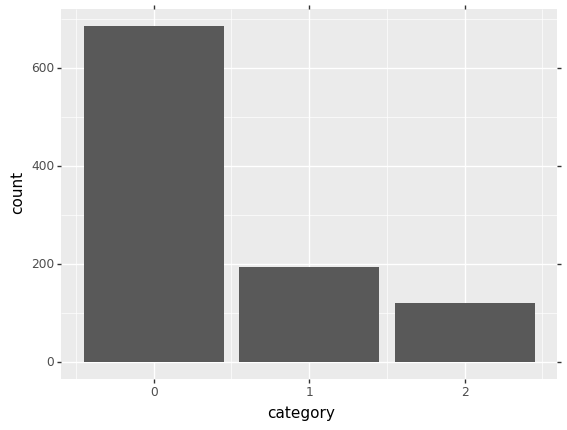

<ggplot: (8749401556095)>

In [7]:
#see percentage of customer categories


(ggplot(small)        
 + aes(x='category')    
 + geom_bar(size=20) 
)

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


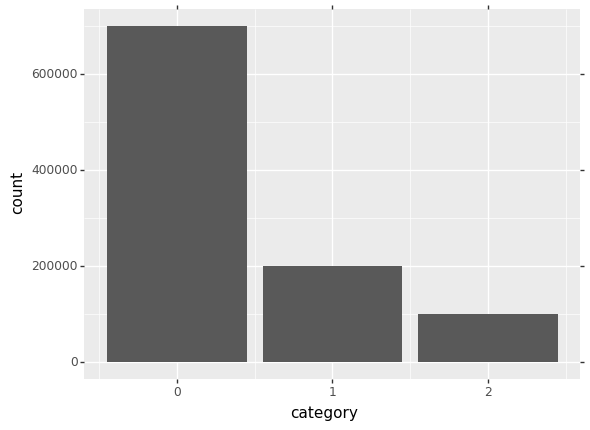

<ggplot: (8749401558676)>

In [8]:
(ggplot(large)         # defining what data to use
 + aes(x='category')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


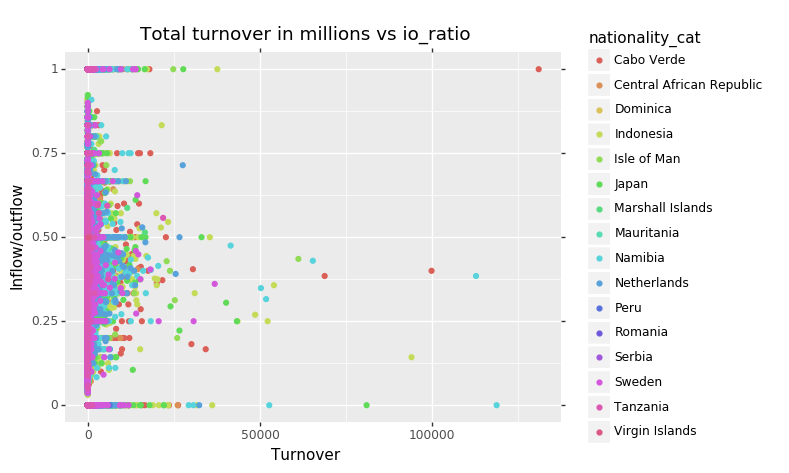

<ggplot: (-9223363287456888565)>

In [9]:
#add nationality names to see in the plot, and turnover in millions to see the graph better
small['nationality_cat']= np.array(countries['country_name'])[small['nationality']-1]
large['nationality_cat']= np.array(countries['country_name'])[large['nationality']-1]
small['turnover_mil']= np.array(small['turnover'])/1000000
large['turnover_mil']= np.array(large['turnover'])/1000000

#see outliers and the countries of them
(ggplot(large)
 + aes(x='turnover_mil', y='io_ratio', color='nationality_cat')
 + geom_point()
 + labs(title='Total turnover in millions vs io_ratio', x='Turnover', y='Inflow/outflow')
)

In [11]:
#remove outliers with IsolationForest
X_train= large.loc[:, large.columns != 'nationality_cat']
X_train= X_train.loc[:, X_train.columns != 'cif']
X_train= X_train.loc[:, X_train.columns != 'nationality']

from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, max_features=10)
clf.fit(X_train)
decision= clf.decision_function(X_train)
removed_out= X_train[decision>0]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


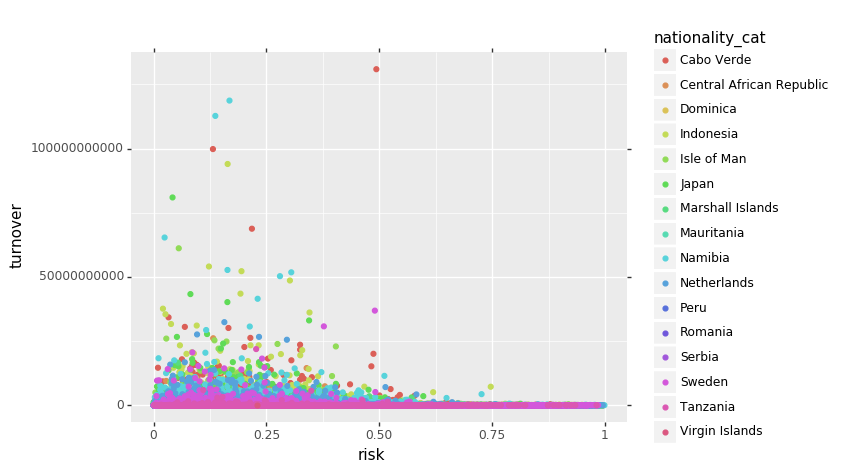

<ggplot: (8749394897051)>

In [12]:
#also check the risk with respect to country
(ggplot(large)
 + aes(x='channel_risk', y='turnover', color='nationality_cat')
 + geom_point()
 + labs(title='', x='risk', y='turnover')
)

In [32]:
#use the labels for training the algorithm
label_file= file_path+ 'jeopardy.csv'
labels= pd.read_csv(label_file)
labels= labels['suspicious']

removed_out['labels']= labels
large['labels']= labels


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
all_data= large.loc[:, large.columns != 'labels']
all_data= all_data.loc[:, all_data.columns != 'cif']
all_data= all_data.loc[:, all_data.columns != 'nationality_cat']


Cabo Verde , 0.01355795482750062 , 225624
Central African Republic , 0.056572463039324145 , 19886
Dominica , 0.6666666666666666 , 3
Indonesia , 0.010762139658550237 , 228672
Isle of Man , 0.039907791219017004 , 47284
Japan , 0.009611087723843139 , 154405
Marshall Islands , 0.09190009659169311 , 7247
Mauritania , 0.47368421052631576 , 19
Namibia , 0.01786115957711972 , 164491
Netherlands , 0.025175807267733042 , 96839
Peru , 0.23865110246433205 , 771
Romania , 0.30414746543778803 , 217
Serbia , 0.43636363636363634 , 55
Sweden , 0.007929498502419169 , 52084
Tanzania , 0.15986677768526228 , 2402
Virgin Islands  , 1.0 , 1


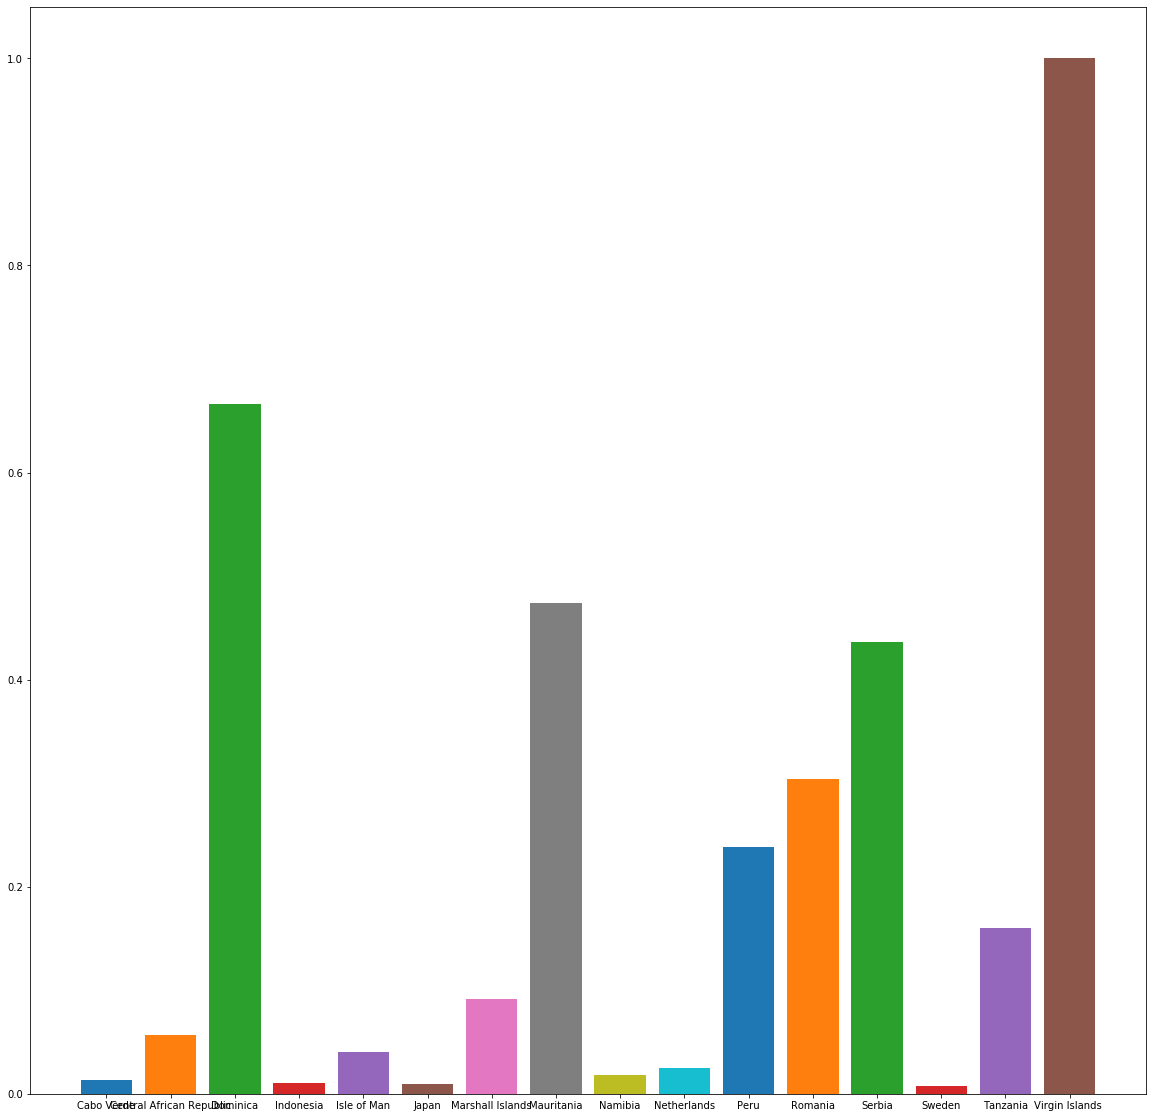

In [34]:
#percentages of suspicious people are useful for deducing the suspicious countries
countries_percentages= []
for i in np.unique(large['nationality_cat']):
    a= np.sum(labels[large['nationality_cat']==i])/len(labels[large['nationality_cat']==i])
    plt.rcParams['figure.figsize'] = [20, 20]
    print(i,",",a,",", len(labels[large['nationality_cat']==i]))
    plt.bar(i,a)
    countries_percentages.append(a)

In [0]:
#See different customer categories
labels= np.array(labels)
cat_0= all_data[all_data['category']==0]
cat_0_labels= labels[all_data['category']==0]
cat_1= all_data[all_data['category']==1]
cat_1_labels= labels[all_data['category']==1]
cat_2= all_data[all_data['category']==2]
cat_2_labels= labels[all_data['category']==2]


In [0]:
#there is a high bias against positive samples. thus we weight the positive samples more in 
#training to be able not get a lot of false negatives. detecting the fradulent activity is more important than a false alarm in this case.
weight_col= labels.copy()
weight_col[weight_col==1]= 10
weight_col[weight_col==0]= 1


In [61]:
#training the xgboost algorithm for individual customer accounts
accs0=[]
f1s0=[]
skf = StratifiedKFold(n_splits=5)
#undersample the nonfradulent samples for reducing imbalance in data, the train with everything
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(cat_0,cat_0_labels)
ind= rus.sample_indices_
cat_0= X_rus
cat_0_labels= y_rus
print("Confusion matrices")
i=1
for train_ind, test_ind in skf.split(cat_0,cat_0_labels ):
    xgb0= xgbo.XGBClassifier(n_estimators=350, max_depth=5,objective='binary:logistic', booster='gbtree', tree_method='hist', verbosity=0)
    x_train= np.array(cat_0)[train_ind]
    x_test= np.array(cat_0)[test_ind]
    y_train= np.array(cat_0_labels)[train_ind]
    y_test=np.array(cat_0_labels)[test_ind]
    xgb0.fit(x_train, y_train, sample_weight= weight_col[train_ind], eval_metric="aucpr",eval_set= [(x_test, y_test)], verbose=0) 
    pred= xgb0.predict(x_test)
    newpred= pred.copy()
    newpred[pred>0.5]= 1
    newpred[pred<0.5]= 0
    print("Fold", i)
    i=i+1
    print(confusion_matrix(y_test,newpred))

    acc= accuracy_score(y_test,newpred)
    f1= f1_score(y_test,newpred)
    accs0.append(acc)
    f1s0.append(f1)
print("Accuracies through folds :")
print(accs0)
print("F1 Scores through folds :")
print(f1s0)

Confusion matrices
Fold 1
[[2160  638]
 [ 631 2167]]
Fold 2
[[2138  660]
 [ 606 2192]]
Fold 3
[[2150  648]
 [ 637 2161]]
Fold 4
[[2173  625]
 [ 611 2187]]
Fold 5
[[2187  610]
 [ 649 2148]]
Accuracies through folds :
[0.7732308791994281, 0.7737669764117227, 0.7703716940671909, 0.7791279485346676, 0.7749374329638898]
F1 Scores through folds :
[0.773514188827414, 0.775929203539823, 0.7708221865525237, 0.7796791443850267, 0.7733573357335733]


In [62]:
#training the xgboost algorithm for  company accounts
accs1=[]
f1s1=[]
skf = StratifiedKFold(n_splits=5)

#undersample the nonfradulent samples for reducing imbalance in data, the train with everything
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(cat_1,cat_1_labels)
ind= rus.sample_indices_
cat_1= X_rus
cat_1_labels= y_rus
print("Confusion matrices")
i=1
for train_ind, test_ind in skf.split(cat_1,cat_1_labels ):
    xgb1= xgbo.XGBClassifier(n_estimators=350, max_depth=5,objective='binary:logistic', booster='gbtree', tree_method='hist', verbosity=0)
    x_train= np.array(cat_1)[train_ind]
    x_test= np.array(cat_1)[test_ind]
    y_train= np.array(cat_1_labels)[train_ind]
    y_test=np.array(cat_1_labels)[test_ind]
    xgb1.fit(x_train, y_train, sample_weight= weight_col[train_ind], eval_metric="aucpr",eval_set= [(x_test, y_test)], verbose=0) 
    pred= xgb1.predict(x_test)
    newpred= pred.copy()
    newpred[pred>0.5]= 1
    newpred[pred<0.5]= 0
    print("Fold", i)
    i=i+1
    print(confusion_matrix(y_test,newpred))

    acc= accuracy_score(y_test,newpred)
    f1= f1_score(y_test,newpred)
    accs1.append(acc)
    f1s1.append(f1)
print("Accuracies through folds :")
print(accs1)
print("F1 Scores through folds :")
print(f1s1)

Confusion matrices
Fold 1
[[312 105]
 [102 315]]
Fold 2
[[323  94]
 [118 299]]
Fold 3
[[319  98]
 [100 317]]
Fold 4
[[302 114]
 [ 83 333]]
Fold 5
[[329  87]
 [105 311]]
Accuracies through folds :
[0.7517985611510791, 0.7458033573141487, 0.762589928057554, 0.7632211538461539, 0.7692307692307693]
F1 Scores through folds :
[0.7526881720430109, 0.7382716049382715, 0.7620192307692308, 0.7717265353418309, 0.7641277641277641]


In [63]:
#training the xgboost algorithm for  other accounts
accs2=[]
f1s2=[]
skf = StratifiedKFold(n_splits=5)
#undersample the nonfradulent samples for reducing imbalance in data, the train with everything
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(cat_2,cat_2_labels)
ind= rus.sample_indices_
cat_2= X_rus
cat_2_labels= y_rus
print("Confusion matrices")
i=1
for train_ind, test_ind in skf.split(cat_2,cat_2_labels ):
    xgb2= xgbo.XGBClassifier(n_estimators=350, max_depth=5,objective='binary:logistic', booster='gbtree', tree_method='hist', verbosity=0)
    x_train= np.array(cat_2)[train_ind]
    x_test= np.array(cat_2)[test_ind]
    y_train= np.array(cat_2_labels)[train_ind]
    y_test=np.array(cat_2_labels)[test_ind]
    xgb2.fit(x_train, y_train, sample_weight= weight_col[train_ind], eval_metric="aucpr",eval_set= [(x_test, y_test)], verbose=0) 
    pred= xgb2.predict(x_test)
    newpred= pred.copy()
    newpred[pred>0.5]= 1
    newpred[pred<0.5]= 0
    print("Fold", i)
    i=i+1
    print(confusion_matrix(y_test,newpred))

    acc= accuracy_score(y_test,newpred)
    f1= f1_score(y_test,newpred)
    accs2.append(acc)
    f1s2.append(f1)
print("Accuracies through folds :")
print(accs2)
print("F1 Scores through folds :")
print(f1s2)

Confusion matrices
Fold 1
[[174  40]
 [ 47 167]]
Fold 2
[[169  45]
 [ 42 172]]
Fold 3
[[179  35]
 [ 40 174]]
Fold 4
[[170  44]
 [ 51 163]]
Fold 5
[[171  42]
 [ 39 174]]
Accuracies through folds :
[0.7967289719626168, 0.7967289719626168, 0.8247663551401869, 0.7780373831775701, 0.8098591549295775]
F1 Scores through folds :
[0.7933491686460808, 0.7981438515081206, 0.8226950354609928, 0.7743467933491688, 0.8111888111888113]


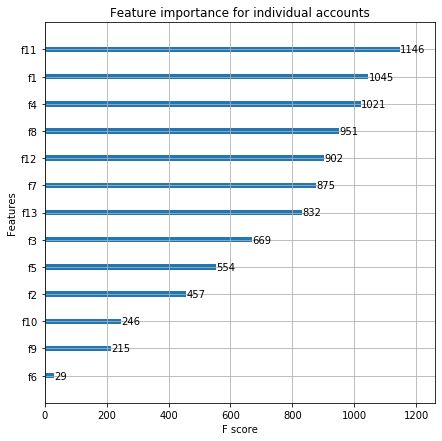

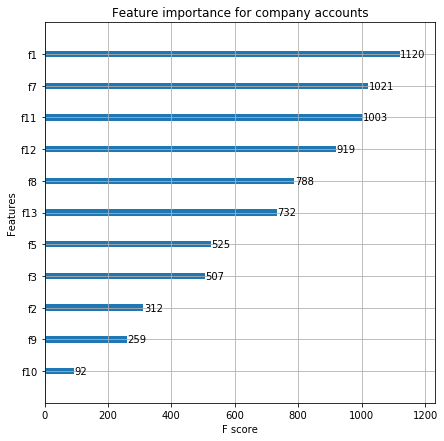

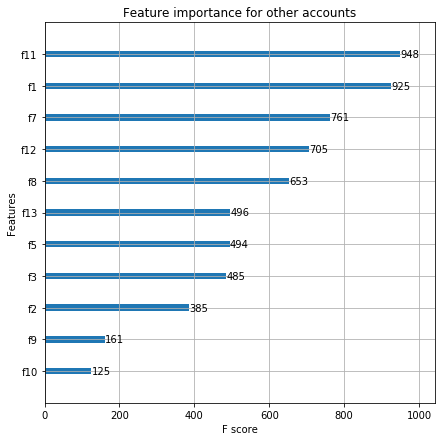

In [68]:
plt.rcParams['figure.figsize'] = [7, 7]

xgbo.plot_importance(xgb0, max_num_features=15, title= "Feature importance for individual accounts")
plt.show()

xgbo.plot_importance(xgb1, max_num_features=15, title="Feature importance for company accounts")
plt.show()

xgbo.plot_importance(xgb2, max_num_features=15, title= "Feature importance for other accounts")
plt.show()


We see that f11 has the most importance in individual and other accounts whereas f1 has the most importance for the company accounts. f11 is channel_risk for the customer transaction and f1 is the turnover. This means we can differentiate the individuals and companies before going into the algorithm to classify between suspicious or not.

Confusion Matrices
Fold 1
[[3729   24]
 [ 182   43]]
Fold 2
[[3739   13]
 [ 182   43]]
Fold 3
[[3740   12]
 [ 182   43]]
Fold 4
[[3732   20]
 [ 184   41]]
Fold 5
[[3739   13]
 [ 173   52]]
Accuracies through folds :
[0.9482151835093011, 0.9509680663816947, 0.9512195121951219, 0.9487050540608499, 0.9532310787025396]
F1 Scores through folds :
[0.2945205479452055, 0.30604982206405695, 0.3071428571428571, 0.2867132867132868, 0.3586206896551724]


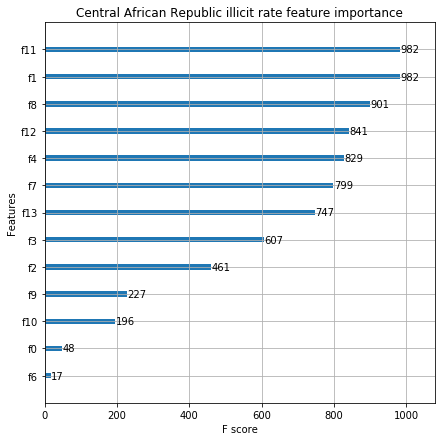

In [71]:
#Check a specific country, say Central African Republic since it has a suspicious rate of 5 %
central= all_data[all_data['nationality']==33]
central_labels= labels[all_data['nationality']==33]
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgbo
all_data= all_data.loc[:, all_data.columns != 'turnover_mil']

print("Confusion Matrices")
accs=[]
f1s=[]
skf = StratifiedKFold(n_splits=5)
i=1
for train_ind, test_ind in skf.split(central,central_labels ):
    xgb= xgbo.XGBClassifier(n_estimators=350, max_depth=5,objective='binary:logistic', booster='gbtree', tree_method='hist', verbosity=0)
    x_train= np.array(central)[train_ind]
    x_test= np.array(central)[test_ind]
    y_train= np.array(central_labels)[train_ind]
    y_test=np.array(central_labels)[test_ind]
    xgb.fit(x_train, y_train, sample_weight= weight_col[train_ind], eval_metric="auc",eval_set= [(x_test, y_test)], verbose=0) 
    pred= xgb.predict(x_test)
    newpred= pred.copy()
    newpred[pred>0.5]= 1
    newpred[pred<0.5]= 0
    print("Fold", i)
    i=i+1
    print(confusion_matrix(y_test,newpred))

    acc= accuracy_score(y_test,newpred)
    f1= f1_score(y_test,newpred)
    accs.append(acc)
    f1s.append(f1)
print("Accuracies through folds :")

print(accs)
print("F1 Scores through folds :")

print(f1s)

xgbo.plot_importance(xgb, max_num_features=15, title= "Central African Republic illicit rate feature importance")
